Сделайте несколько усовершенствований в предсказании временного ряда

1. Добавьте к исходному временному ряду следующие данные, в виде новых каналов:

попарные разности каналов
модули попарных разностей каналов
попарные произведения каналов
обратное значение каналов x_new = 1/(x + 1e-3)
первые производные каналов (x[n] - x[n-1])
вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])
2. Сделайте предсказание нейросети, сравните эталонный сигнал с настоящим. При формировании входного сигнала используйте:

100 точек с шагом назад по 1
100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
base_data16 = pd.read_csv('/content/drive/My Drive/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data = pd.concat([data16_17, data18_19])
data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231


In [ ]:
import itertools

list_columns = [data['OPEN'], data['MAX'], data['MIN'], data['CLOSE'], data['VOLUME']]
for pair in itertools.combinations(list_columns, r=2):
  data[str(data.shape[1]+1)] = pair[0] - pair[1]

data.head()
# добавили попарные разности первых пяти каналов

,OPEN,MAX,MIN,CLOSE,VOLUME,6,7,8,9,10,11,12,13,14,15
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,1.0,1.0,-196.0,5.8,5.8,-191.2,0.0,-197.0,-197.0
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.9,-2.8,2157.9,5.7,0.0,2160.7,-5.7,2155.0,2160.7
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,-2.7,2094.4,2097.1
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,-2.5,1588.2,1590.7
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.0,-0.5,2122.1,0.8,0.3,2122.9,-0.5,2122.1,2122.6


In [ ]:
for pair in itertools.combinations(list_columns, r=2):
  data[str(data.shape[1]+1)] = abs(pair[0] - pair[1])

data.head()
# аналогично модули

,OPEN,MAX,MIN,CLOSE,VOLUME,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,1.0,1.0,-196.0,5.8,5.8,-191.2,0.0,-197.0,-197.0,4.8,1.0,1.0,196.0,5.8,5.8,191.2,0.0,197.0,197.0
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.9,-2.8,2157.9,5.7,0.0,2160.7,-5.7,2155.0,2160.7,2.8,2.9,2.8,2157.9,5.7,0.0,2160.7,5.7,2155.0,2160.7
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,-2.7,2094.4,2097.1,0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,2.7,2094.4,2097.1
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,-2.5,1588.2,1590.7,0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,2.5,1588.2,1590.7
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.0,-0.5,2122.1,0.8,0.3,2122.9,-0.5,2122.1,2122.6,0.8,0.0,0.5,2122.1,0.8,0.3,2122.9,0.5,2122.1,2122.6


In [ ]:
for pair in itertools.combinations(list_columns, r=2):
  data[str(data.shape[1]+1)] = pair[0] * pair[1]

data.head()
# ...произведения

,OPEN,MAX,MIN,CLOSE,VOLUME,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,1.0,1.0,-196.0,5.8,5.8,-191.2,0.0,-197.0,-197.0,4.8,1.0,1.0,196.0,5.8,5.8,191.2,0.0,197.0,197.0,5538485.80,5524850.00,5524850.00,5987997.0,5536130.00,5536130.00,6000222.6,5522500.00,5985450.0,5985450.0
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.9,-2.8,2157.9,5.7,0.0,2160.7,-5.7,2155.0,2160.7,2.8,2.9,2.8,2157.9,5.7,0.0,2160.7,5.7,2155.0,2160.7,5542726.53,5529315.00,5542726.53,458815.5,5535895.00,5549322.49,459361.5,5535895.00,458250.0,459361.5
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,-2.7,2094.4,2097.1,0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,2.7,2094.4,2097.1,5549793.60,5538957.84,5545317.96,605389.2,5539898.40,5546259.60,605492.0,5535430.74,604309.8,605003.7
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,-2.5,1588.2,1590.7,0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,2.5,1588.2,1590.7,5544847.50,5535900.40,5541786.65,1796483.5,5537076.00,5542963.50,1796865.0,5534019.44,1793965.6,1795873.1
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.0,-0.5,2122.1,0.8,0.3,2122.9,-0.5,2122.1,2122.6,0.8,0.0,0.5,2122.1,0.8,0.3,2122.9,0.5,2122.1,2122.6,5538962.09,5537079.61,5538256.16,543566.1,5538962.09,5540139.04,543750.9,5538256.16,543566.1,543681.6


In [ ]:
for i in list_columns:
  data[str(data.shape[1]+1)] = 1/(i + 1e-3)

data.head()
# обратные значения каналов

,OPEN,MAX,MIN,CLOSE,VOLUME,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,1.0,1.0,-196.0,5.8,5.8,-191.2,0.0,-197.0,-197.0,4.8,1.0,1.0,196.0,5.8,5.8,191.2,0.0,197.0,197.0,5538485.80,5524850.00,5524850.00,5987997.0,5536130.00,5536130.00,6000222.6,5522500.00,5985450.0,5985450.0,0.000425,0.000424,0.000426,0.000426,0.000393
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.9,-2.8,2157.9,5.7,0.0,2160.7,-5.7,2155.0,2160.7,2.8,2.9,2.8,2157.9,5.7,0.0,2160.7,5.7,2155.0,2160.7,5542726.53,5529315.00,5542726.53,458815.5,5535895.00,5549322.49,459361.5,5535895.00,458250.0,459361.5,0.000425,0.000425,0.000426,0.000425,0.005128
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,-2.7,2094.4,2097.1,0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,2.7,2094.4,2097.1,5549793.60,5538957.84,5545317.96,605389.2,5539898.40,5546259.60,605492.0,5535430.74,604309.8,605003.7,0.000425,0.000424,0.000425,0.000425,0.003891
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,-2.5,1588.2,1590.7,0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,2.5,1588.2,1590.7,5544847.50,5535900.40,5541786.65,1796483.5,5537076.00,5542963.50,1796865.0,5534019.44,1793965.6,1795873.1,0.000425,0.000425,0.000425,0.000425,0.001311
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.0,-0.5,2122.1,0.8,0.3,2122.9,-0.5,2122.1,2122.6,0.8,0.0,0.5,2122.1,0.8,0.3,2122.9,0.5,2122.1,2122.6,5538962.09,5537079.61,5538256.16,543566.1,5538962.09,5540139.04,543750.9,5538256.16,543566.1,543681.6,0.000425,0.000425,0.000425,0.000425,0.004329


In [ ]:
from sympy import diff

for i in list_columns:
  data[str(data.shape[1]+1)] = diff(i)
  data[str(data.shape[1]+1)] = diff(diff(i))

data.head()
# произовдные

,OPEN,MAX,MIN,CLOSE,VOLUME,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,1.0,1.0,-196.0,5.8,5.8,-191.2,0.0,-197.0,-197.0,4.8,1.0,1.0,196.0,5.8,5.8,191.2,0.0,197.0,197.0,5538485.80,5524850.00,5524850.00,5987997.0,5536130.00,5536130.00,6000222.6,5522500.00,5985450.0,5985450.0,0.000425,0.000424,0.000426,0.000426,0.000393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.9,-2.8,2157.9,5.7,0.0,2160.7,-5.7,2155.0,2160.7,2.8,2.9,2.8,2157.9,5.7,0.0,2160.7,5.7,2155.0,2160.7,5542726.53,5529315.00,5542726.53,458815.5,5535895.00,5549322.49,459361.5,5535895.00,458250.0,459361.5,0.000425,0.000425,0.000426,0.000425,0.005128,1.9,NaN,-0.1,NaN,0.0,NaN,5.7,NaN,-2352.0,NaN
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,-2.7,2094.4,2097.1,0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,2.7,2094.4,2097.1,5549793.60,5538957.84,5545317.96,605389.2,5539898.40,5546259.60,605492.0,5535430.74,604309.8,605003.7,0.000425,0.000424,0.000425,0.000425,0.003891,2.7,0.8,0.3,0.4,1.4,1.4,-1.6,-7.3,62.0,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,-2.5,1588.2,1590.7,0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,2.5,1588.2,1590.7,5544847.50,5535900.40,5541786.65,1796483.5,5537076.00,5542963.50,1796865.0,5534019.44,1793965.6,1795873.1,0.000425,0.000425,0.000425,0.000425,0.001311,-1.1,-3.8,-1.0,-1.3,-0.2,-1.6,-0.4,1.2,506.0,444.0
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.0,-0.5,2122.1,0.8,0.3,2122.9,-0.5,2122.1,2122.6,0.8,0.0,0.5,2122.1,0.8,0.3,2122.9,0.5,2122.1,2122.6,5538962.09,5537079.61,5538256.16,543566.1,5538962.09,5540139.04,543750.9,5538256.16,543566.1,543681.6,0.000425,0.000425,0.000425,0.000425,0.004329,-1.4,-0.3,-1.1,-0.1,1.9,2.1,-0.1,0.3,-532.0,-1038.0


In [ ]:
data.shape

(481872, 50)

In [ ]:
data = data.dropna(axis=0)
data.shape

(481870, 50)

In [ ]:
data = np.array(data)
print(len(data))

481870


In [ ]:
xLen = 100
valLen = 30000

trainLen = data.shape[0] - valLen

xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain, yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

trainDatagen = TimeseriesGenerator(xTrain,yTrain,length=xLen,stride=1,sampling_rate=1,batch_size=20)
testDatagen = TimeseriesGenerator(xTest,yTest,length=xLen,stride=1,batch_size=20)

trainDatagen1 = TimeseriesGenerator(xTrain,yTrain,length=xLen,stride=10,sampling_rate=10,batch_size=20)
testDatagen1 = TimeseriesGenerator(xTest,yTest,length=xLen,stride=10,batch_size=20)

In [ ]:
print(trainDatagen[0][0].shape,
      trainDatagen[0][1].shape)
print(trainDatagen1[0][0].shape,
      trainDatagen1[0][1].shape)

(20, 100, 50) (20, 1)
(20, 10, 50) (20, 1)


In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

In [ ]:
def showPredict(start,step,channel,predVal,yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step,0], label='Predict')
  plt.plot(yValUnscaled[start:start+step, channel],label='Base')
  plt.xlabel('Time')
  plt.ylabel('Price of Close')
  plt.legend()
  plt.show()

In [ ]:
def correlate(a,b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

In [ ]:
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:,0]))
    own_corr = []
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))
    plt.figure(figsize=(14,7))
    plt.plot(corr, label="Predict on " + str(ch+1) + ' stride')
    plt.plot(own_corr, label='Ideal')
  plt.xlabel("Time")
  plt.ylabel('Value')
  plt.legend()
  plt.show()

In [ ]:
DataGen = TimeseriesGenerator(xTest,yTest,length=100,sampling_rate=1,batch_size=len(xTest))
DataGen1 = TimeseriesGenerator(xTest,yTest,length=100,sampling_rate=10,batch_size=len(xTest))

In [ ]:
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])
xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
xVal1 = []
yVal1 = []
for i in DataGen1:
  xVal1.append(i[0])
  yVal1.append(i[1])
xVal1 = np.array(xVal)
yVal1 = np.array(yVal)

In [ ]:
model = Sequential()
model.add(LSTM(5,input_shape=(xLen,50)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=Adam(lr=1e-5))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 1120      
_________________________________________________________________
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,191
Trainable params: 1,191
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainDatagen,epochs=20,verbose=1,validation_data=testDatagen)

Epoch 1/20
22589/22589 [==============================] - 377s 16ms/step - loss: 0.0282 - val_loss: 2.4773e-04
Epoch 2/20
22589/22589 [==============================] - 368s 16ms/step - loss: 4.9075e-05 - val_loss: 3.0498e-05
Epoch 3/20
22589/22589 [==============================] - 369s 16ms/step - loss: 1.4753e-05 - val_loss: 1.5992e-05
Epoch 4/20
22589/22589 [==============================] - 368s 16ms/step - loss: 8.5174e-06 - val_loss: 1.1109e-05
Epoch 5/20
22589/22589 [==============================] - 370s 16ms/step - loss: 5.4826e-06 - val_loss: 6.8288e-06
Epoch 6/20
22589/22589 [==============================] - 368s 16ms/step - loss: 3.7715e-06 - val_loss: 4.8047e-06
Epoch 7/20
22589/22589 [==============================] - 372s 16ms/step - loss: 2.8838e-06 - val_loss: 3.0916e-06
Epoch 8/20
22589/22589 [==============================] - 378s 17ms/step - loss: 2.3626e-06 - val_loss: 2.6489e-06
Epoch 9/20
22589/22589 [==============================] - 371s 16ms/step - loss: 2.0

In [ ]:
history1 = model.fit(trainDatagen1,epochs=20,verbose=1,validation_data=testDatagen1)

Epoch 1/20
2259/2259 [==============================] - 12s 5ms/step - loss: 2.1434e-05 - val_loss: 0.0042
Epoch 2/20
2259/2259 [==============================] - 12s 5ms/step - loss: 8.2536e-06 - val_loss: 0.0040
Epoch 3/20
2259/2259 [==============================] - 12s 5ms/step - loss: 7.8670e-06 - val_loss: 0.0038
Epoch 4/20
2259/2259 [==============================] - 12s 5ms/step - loss: 7.7888e-06 - val_loss: 0.0038
Epoch 5/20
2259/2259 [==============================] - 12s 5ms/step - loss: 7.6734e-06 - val_loss: 0.0038
Epoch 6/20
2259/2259 [==============================] - 12s 5ms/step - loss: 7.6191e-06 - val_loss: 0.0039
Epoch 7/20
2259/2259 [==============================] - 12s 5ms/step - loss: 7.4734e-06 - val_loss: 0.0037
Epoch 8/20
2259/2259 [==============================] - 12s 5ms/step - loss: 7.4410e-06 - val_loss: 0.0037
Epoch 9/20
2259/2259 [==============================] - 12s 5ms/step - loss: 7.4001e-06 - val_loss: 0.0037
Epoch 10/20
2259/2259 [==============

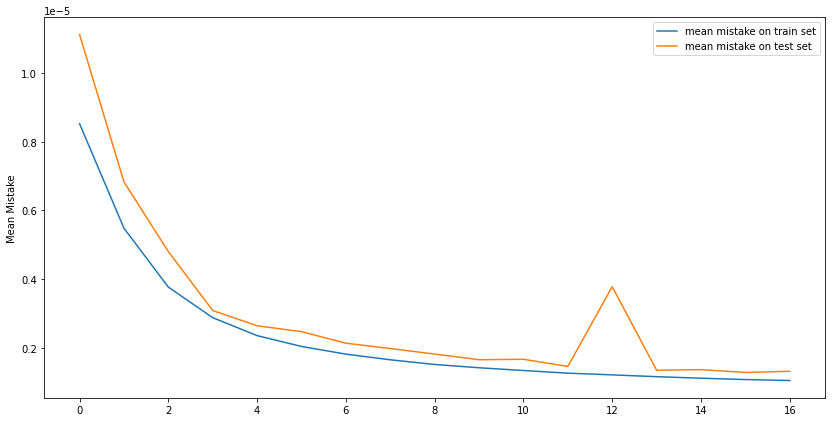

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][3:],label='mean mistake on train set')
plt.plot(history.history['val_loss'][3:], label='mean mistake on test set')
plt.ylabel('Mean Mistake')
plt.legend()
plt.show()

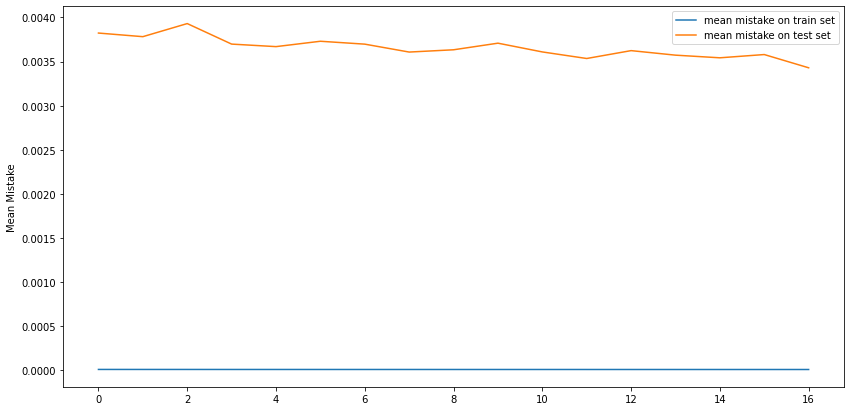

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history1.history['loss'][3:],label='mean mistake on train set')
plt.plot(history1.history['val_loss'][3:], label='mean mistake on test set')
plt.ylabel('Mean Mistake')
plt.legend()
plt.show()

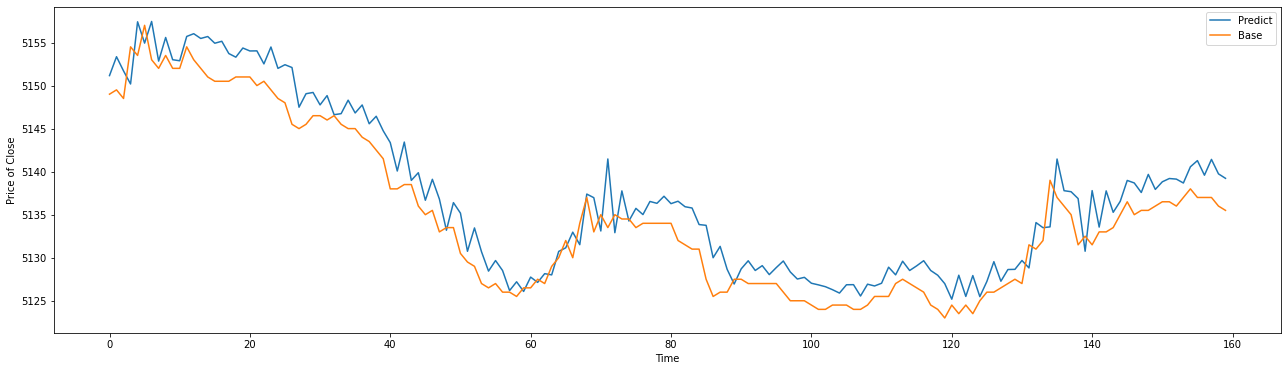

In [ ]:
(predVal,yValUnscaled) = getPred(model, xVal[0],yVal[0],yScaler)
showPredict(0,160,0,predVal,yValUnscaled)

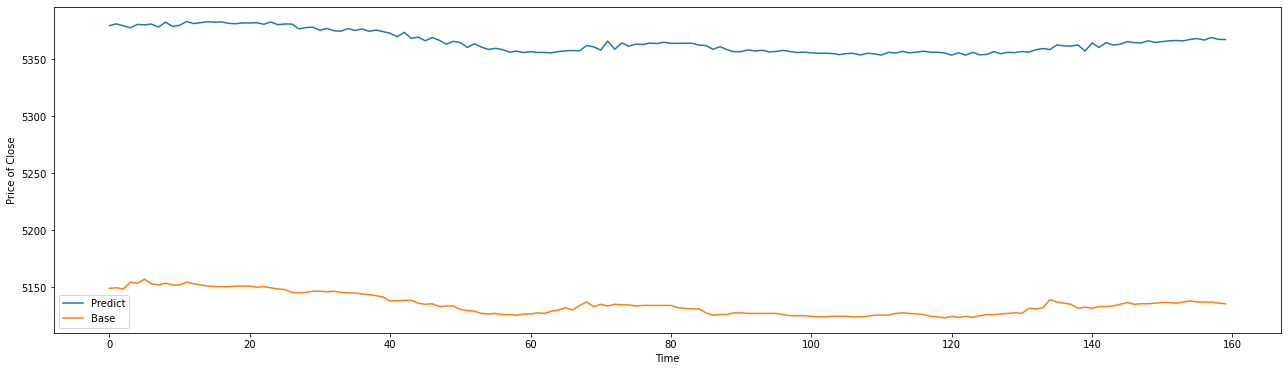

In [ ]:
(predVal1,yValUnscaled1) = getPred(model, xVal1[0],yVal1[0],yScaler)
showPredict(0,160,0,predVal1,yValUnscaled1)

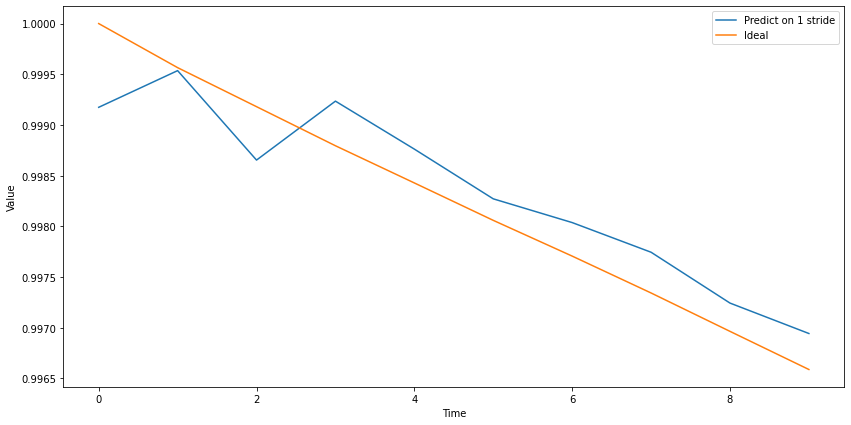

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

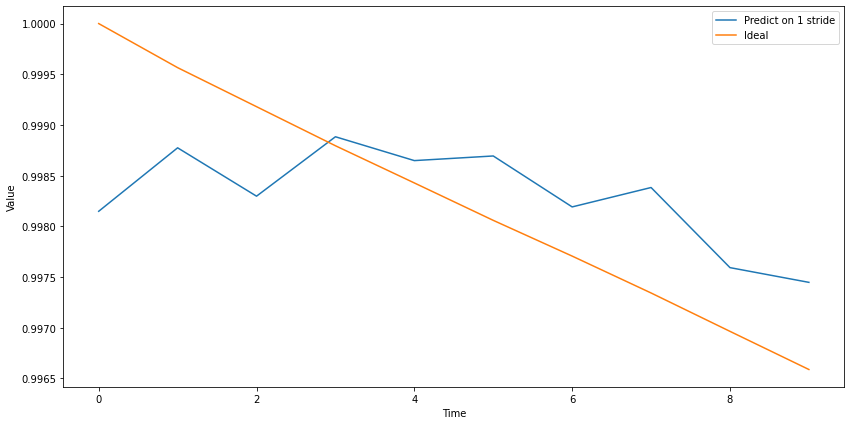

In [ ]:
showCorr([0], 10, predVal1, yValUnscaled1)

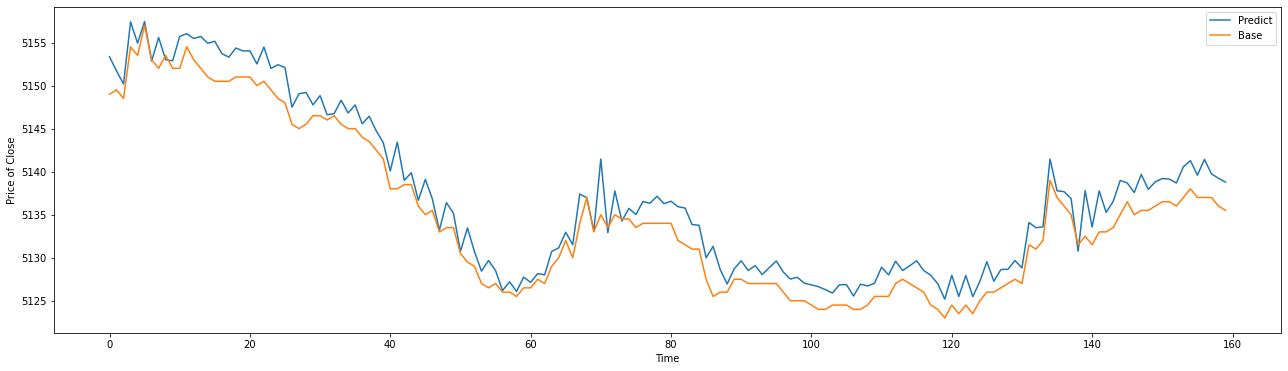

In [ ]:
(predVal, yValUnscaled) = getPred(model, xVal[0], yVal[0], yScaler)
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])

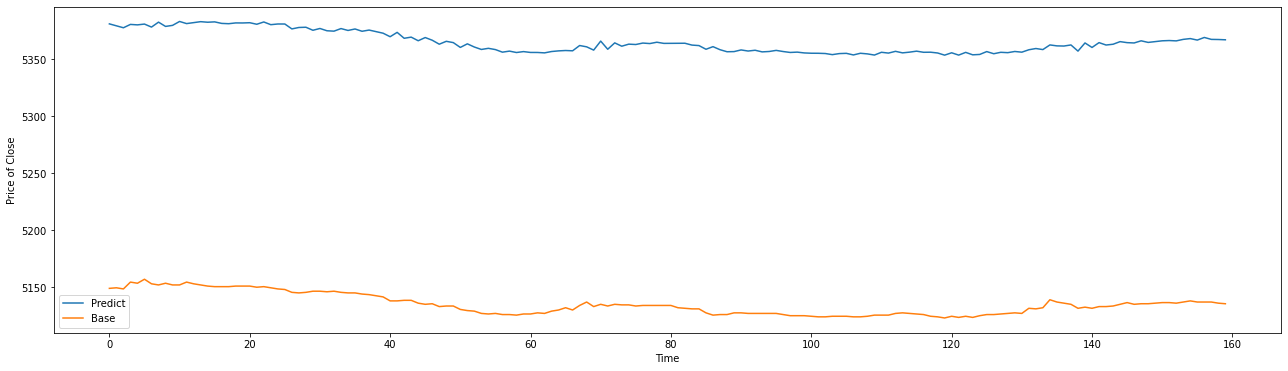

In [ ]:
(predVal1, yValUnscaled1) = getPred(model, xVal1[0], yVal1[0], yScaler)
showPredict(0, 160, 0, predVal1[1:], yValUnscaled1[:-1])